In [9]:
# ============================================
# PREPROCESSING FOR ALL EIRSAT-1 DATASETS
# (Flight-Test + TVAC + ALL on-orbit channel CSVs)
# Notebook-friendly (same “manual” style)
# ============================================

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ------------------------------------------------------------
# 0) Paths (EDIT for your local machine OR use the uploaded paths)
# ------------------------------------------------------------
# If you're running in your own laptop (Windows):
# BASE = r"C:\sujit\SEM-4\ML_PROJECT\EIRSAT-1 Dataset\EIRSAT-1 Dataset"

# If you're running here (uploaded files):


BASE = r"E:\ML_Project_Dataset\EIRSAT-1 Dataset"

FLIGHTTEST_PATH = os.path.join(BASE, "Flight Test Data", "flighttest_dataset.csv")
TVAC_PATH       = os.path.join(BASE, "TVAC Test Data", "tvac_dataset.csv")

ORBIT_PATHS = [
    os.path.join(BASE, "Flight Data", "channel_15Dec.csv"),
    os.path.join(BASE, "Flight Data", "channel_16Dec.csv"),
    os.path.join(BASE, "Flight Data", "channel_17Dec.csv"),
    os.path.join(BASE, "Flight Data", "channel_19Dec.csv"),

    os.path.join(BASE, "Flight Data", "channel_15_Jan.csv"),
    os.path.join(BASE, "Flight Data", "channel_16_Jan.csv"),
    os.path.join(BASE, "Flight Data", "channel_17_Jan.csv"),
    os.path.join(BASE, "Flight Data", "channel_19_Jan.csv"),

    os.path.join(BASE, "Flight Data", "channel_15feb.csv"),
    os.path.join(BASE, "Flight Data", "channel_16Feb.csv"),
    os.path.join(BASE, "Flight Data", "channel_17Feb.csv"),
    os.path.join(BASE, "Flight Data", "channel_19feb.csv"),

    os.path.join(BASE, "Flight Data", "channel_15_Mar.csv"),
    os.path.join(BASE, "Flight Data", "channel_16_Mar.csv"),
    os.path.join(BASE, "Flight Data", "channel_17_Mar.csv"),
    os.path.join(BASE, "Flight Data", "channel_19_Mar.csv"),
]


In [10]:
# ------------------------------------------------------------
# 1) Utility functions
# ------------------------------------------------------------

def load_csv(path):
    df = pd.read_csv(path, low_memory=False)
    return df

def build_anomaly_bin(df):
    """Creates Anomaly_Bin from Anomaly_* columns (Flight-Test/TVAC)."""
    df = df.copy()
    anomaly_cols = [c for c in df.columns if c.lower().startswith("anomaly_")]
    if len(anomaly_cols) == 0:
        return df  # unlabeled/orbit file
    for c in anomaly_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    df["Anomaly_Bin"] = (df[anomaly_cols].sum(axis=1) > 0).astype(int)
    return df

def numeric_feature_frame(df, drop_label=True):
    """Keep numeric columns only; optionally drop Anomaly columns and Anomaly_Bin."""
    X = df.select_dtypes(include=[np.number]).copy()
    # drop anomaly_* columns
    drop_anom = [c for c in X.columns if c.lower().startswith("anomaly_")]
    X = X.drop(columns=drop_anom, errors="ignore")
    if drop_label:
        X = X.drop(columns=["Anomaly_Bin"], errors="ignore")
    return X

def drop_sparse_columns(df, protected_cols=None, missing_thresh=0.95):
    """Drop columns with > missing_thresh missing fraction, except protected."""
    df = df.copy()
    protected_cols = set(protected_cols or [])
    miss = df.isna().mean()
    drop_cols = [c for c in df.columns if (miss[c] > missing_thresh and c not in protected_cols)]
    return df.drop(columns=drop_cols, errors="ignore"), drop_cols

def drop_near_constant_numeric(X, var_thresh=1e-12):
    """Drop numeric columns with ~0 variance."""
    X = X.copy()
    variances = X.var(numeric_only=True)
    drop_cols = variances[variances <= var_thresh].index.tolist()
    return X.drop(columns=drop_cols, errors="ignore"), drop_cols

def find_time_cols(df):
    """Find time-like columns (kept for reference, not used in PCA unless you want)."""
    keys = ["obt", "time", "timestamp", "date"]
    return [c for c in df.columns if any(k in c.lower() for k in keys)]

def median_impute(X):
    """Median imputation for remaining NaNs."""
    return X.fillna(X.median(numeric_only=True))


In [11]:
# ------------------------------------------------------------
# 2) Load ALL datasets
# ------------------------------------------------------------
ft = build_anomaly_bin(load_csv(FLIGHTTEST_PATH))
tv = build_anomaly_bin(load_csv(TVAC_PATH))
    
orbit_dfs = []
orbit_names = []

for p in ORBIT_PATHS:
    if os.path.exists(p):
        orbit_dfs.append(load_csv(p))
        orbit_names.append(os.path.basename(p))
    else:
        print("Missing orbit file (skip):", p)

print("Flight-Test shape:", ft.shape)
print("TVAC shape      :", tv.shape)
print("Orbit files loaded:", len(orbit_dfs))
print("Orbit sample names:", orbit_names[:5])

Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_15Dec.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_16Dec.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_17Dec.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_19Dec.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_15_Jan.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_16_Jan.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_17_Jan.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_19_Jan.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_15feb.csv
Missing orbit file (skip): E:\ML_Project_Dataset\EIRSAT-1 Dataset\Flight Data\channel_16Feb.csv
Missing orbit file (skip): E:\ML_Pro

In [12]:
# ------------------------------------------------------------
# 3) Decide a COMMON FEATURE SET across ALL datasets
#    (Intersection is safest: ensures same columns everywhere)
# ------------------------------------------------------------

# numeric features only
Xft_raw = numeric_feature_frame(ft, drop_label=True)
Xtv_raw = numeric_feature_frame(tv, drop_label=True)

orbit_numeric_list = [numeric_feature_frame(d, drop_label=True) for d in orbit_dfs]

# Common columns across all datasets (intersection)
common_cols = set(Xft_raw.columns) & set(Xtv_raw.columns)
for Xo in orbit_numeric_list:
    common_cols &= set(Xo.columns)

common_cols = sorted(list(common_cols))
print("Common numeric columns across ALL datasets:", len(common_cols))

# Keep time cols separately (for plots/splitting later)
ft_time_cols = find_time_cols(ft)
tv_time_cols = find_time_cols(tv)
print("Flight-Test time-like columns:", ft_time_cols)
print("TVAC time-like columns      :", tv_time_cols)


Common numeric columns across ALL datasets: 252
Flight-Test time-like columns: ['OBT', 'core.OBT.uptime', 'platform.obc.GPS.LastGpsTimeLog', 'platform.obc.GPS.UpdateGpsTimeLog_1', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'payload.GMOD.DP_CPLDTimeoutCounter', 'param readonly uint32 lastSvUpdate', 'param readonly uint16 successfulSvUpdates']
TVAC time-like columns      : ['OBT', 'core.OBT.uptime', 'platform.obc.GPS.LastGpsTimeLog', 'platform.obc.GPS.UpdateGpsTimeLog_1', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'payload.GMOD.DP_CPLDTimeoutCounter', 'param readonly uint32 lastSvUpdate', 'param readonly uint16 successfulSvUpdates']


In [13]:
# ------------------------------------------------------------
# 4) Apply feature alignment + drop sparse + drop near-constant
#    IMPORTANT: We drop sparse/constant based on TRAINABLE BASE (Flight-Test + TVAC combined)
# ------------------------------------------------------------

# Combine labeled to decide which features are usable
labeled_concat = pd.concat([ft[common_cols], tv[common_cols]], axis=0, ignore_index=True)

# Drop very sparse columns (keep none protected because these are numeric feature cols only)
labeled_clean, dropped_sparse = drop_sparse_columns(labeled_concat, protected_cols=[], missing_thresh=0.95)

# Drop near-constant after sparse removal
labeled_clean2, dropped_const = drop_near_constant_numeric(labeled_clean, var_thresh=1e-12)

final_cols = labeled_clean2.columns.tolist()
print("Dropped sparse:", len(dropped_sparse))
print("Dropped constant:", len(dropped_const))
print("Final numeric feature count:", len(final_cols))

# Helper to align any dataset to final_cols
def align_to_final_cols(df_numeric, final_cols):
    X = df_numeric.copy()
    # keep only final_cols that exist
    X = X.reindex(columns=final_cols)
    return X


Dropped sparse: 71
Dropped constant: 12
Final numeric feature count: 169


In [14]:
# Align
Xft = align_to_final_cols(Xft_raw, final_cols)
Xtv = align_to_final_cols(Xtv_raw, final_cols)

# Labels
yft = ft["Anomaly_Bin"].astype(int)
ytv = tv["Anomaly_Bin"].astype(int)

# Impute
Xft_imp = median_impute(Xft)
Xtv_imp = median_impute(Xtv)

# Fit scaler on LABELED data (FT+TVAC combined)
X_labeled_all = pd.concat([Xft_imp, Xtv_imp], axis=0, ignore_index=True)

scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled_all)

# PCA retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_labeled_pca = pca.fit_transform(X_labeled_scaled)

print("PCA components:", X_labeled_pca.shape[1])
print("Variance retained:", float(pca.explained_variance_ratio_.sum()))

PCA components: 71
Variance retained: 0.9515495287416811


In [15]:
def transform_with_scaler_pca(X_df, scaler, pca):
    X_imp = median_impute(X_df)
    X_scaled = scaler.transform(X_imp)
    X_pca = pca.transform(X_scaled)
    return X_imp, X_scaled, X_pca

# Flight-Test
Xft_imp2, Xft_scaled, Xft_pca = transform_with_scaler_pca(Xft, scaler, pca)
# TVAC
Xtv_imp2, Xtv_scaled, Xtv_pca = transform_with_scaler_pca(Xtv, scaler, pca)

print("FT PCA shape:", Xft_pca.shape, " | label counts:", yft.value_counts().to_dict())
print("TV PCA shape:", Xtv_pca.shape, " | label counts:", ytv.value_counts().to_dict())

# Orbit files
orbit_processed = []
for name, df_orb, Xo_raw in zip(orbit_names, orbit_dfs, orbit_numeric_list):
    Xo = align_to_final_cols(Xo_raw, final_cols)
    Xo_imp, Xo_scaled, Xo_pca = transform_with_scaler_pca(Xo, scaler, pca)
    orbit_processed.append((name, Xo_pca))
    print("Orbit:", name, "-> PCA shape:", Xo_pca.shape)


FT PCA shape: (72390, 71)  | label counts: {0: 55055, 1: 17335}
TV PCA shape: (61109, 71)  | label counts: {0: 57583, 1: 3526}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the datasets
df_tvac = pd.read_csv('/content/drive/MyDrive/tvac_dataset.csv')
df_flight = pd.read_csv('/content/drive/MyDrive/flighttest_dataset.csv')

print(f"TVAC Shape: {df_tvac.shape}")
print(f"Flight Test Shape: {df_flight.shape}")

# The paper describes anomalies by specific parameter behaviors.
# We reconstruct 'Anomaly_Bin' based on Section V of the paper.

def tag_tvac_anomalies(row):
    # TVAC Anomaly 1: Battery Voltage drops to 0
    if row['platform.BAT.batteryVoltage[2]'] == 0: # Using index 2 as proxy for voltage param
        return 1
    # TVAC Anomaly 2: Temperature PA drops to 0 [cite: 250]
    if 'platform.CMC.temperaturePA' in row and row['platform.CMC.temperaturePA'] == 0:
        return 1
    return 0

/tmp/ipython-input-2104845964.py:13: DtypeWarning: Columns (178) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flight = pd.read_csv('/content/drive/MyDrive/flighttest_dataset.csv')


TVAC Shape: (61109, 257)
Flight Test Shape: (72390, 258)


In [2]:
# ---- 1) Build Anomaly_Bin (robust) ----

df = pd.read_csv("/content/drive/MyDrive/flighttest_dataset.csv")
anomaly_cols = [c for c in df.columns if c.lower().startswith("anomaly_")]
print("\nAnomaly columns:", anomaly_cols)

for c in anomaly_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["Anomaly_Bin"] = (df[anomaly_cols].sum(axis=1) > 0).astype(int)

/tmp/ipython-input-2649163924.py:3: DtypeWarning: Columns (178) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/flighttest_dataset.csv")



Anomaly columns: ['Anomaly_4', 'Anomaly_1', 'Anomaly_3', 'Anomaly_2', 'Anomaly_5']



Anomaly_Bin counts:
 Anomaly_Bin
0    55055
1    17335
Name: count, dtype: int64


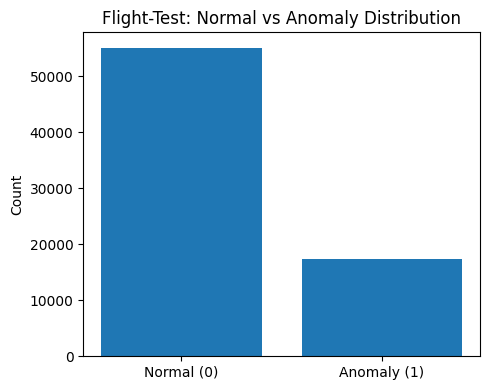

In [3]:
# ---- 2) Label distribution (bar plot) ----
counts = df["Anomaly_Bin"].value_counts().sort_index()
print("\nAnomaly_Bin counts:\n", counts)

plt.figure(figsize=(5,4))
plt.bar(["Normal (0)", "Anomaly (1)"], counts.values)
plt.title("Flight-Test: Normal vs Anomaly Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



Top 20 columns by missing fraction:
 mission.ModeManager.ExitError           0.966031
mission.ModeManager.EntryError          0.966031
platform.obc.GPSSerial.parityErrors     0.966031
platform.obc.GPSSerial.framingErrors    0.966031
GMOD.Serial.parityErrors                0.966031
GMOD.Serial.overrunErrors               0.966031
GMOD.Serial.framingErrors               0.966031
GMOD.Serial.rxFailures                  0.966031
EMOD.Serial.overrunErrors               0.966031
GMOD.Serial.txFailures                  0.966031
EMOD.Serial.rxFailures                  0.966031
EMOD.Serial.txFailures                  0.966031
EMOD.Serial.parityErrors                0.966031
EMOD.Serial.framingErrors               0.966031
payload.GMOD.DP_ForbiddenReadCount      0.966031
payload.GMOD.DP_NonCorrBitErrorCount    0.966031
payload.GMOD.DP_SegFaultType            0.966031
payload.GMOD.DP_CorrBitErrorCount       0.966031
platform.obc.GPS.UpdateGpsTimeLog_0     0.966031
platform.obc.GPS.UpdateGpsTimeL

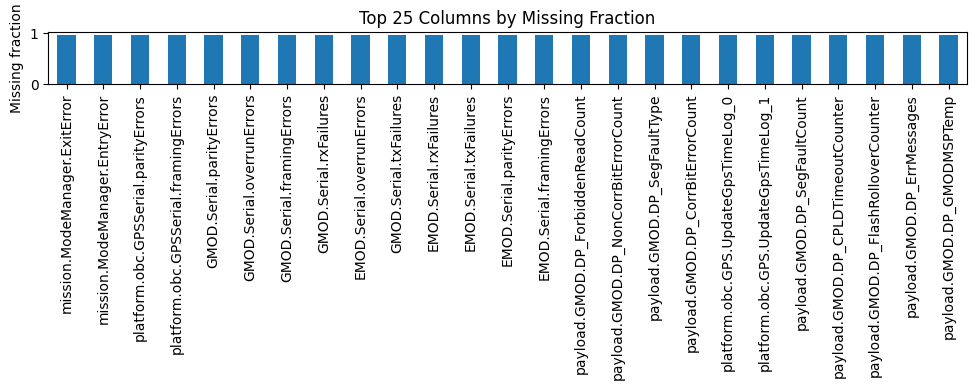

In [4]:
# ---- 3) Missing values (top 25) ----
missing_frac = df.isna().mean().sort_values(ascending=False)
print("\nTop 20 columns by missing fraction:\n", missing_frac.head(20))

plt.figure(figsize=(10,4))
missing_frac.head(25).plot(kind="bar")
plt.title("Top 25 Columns by Missing Fraction")
plt.ylabel("Missing fraction")
plt.tight_layout()
plt.show()


Top 15 mode-dominated features (likely flatline/default):
platform.EPS.busCurrents_3               0.765230
platform.EPS.busVoltages_1               0.740973
platform.EPS.busVoltages_2               0.723000
platform.BAT.batteryCurrentDir           0.675770
platform.EPS.actualSwitchStatesBitmap    0.591808
platform.ADCS.rawGyroRate_0              0.529576
platform.BAT.packedHeaterStatus_0        0.529576
platform.EPS.switchOvercurrentBitmap     0.529576
platform.BAT.packedHeaterStatus_2        0.529576
platform.BAT.packedHeaterStatus_1        0.529576
platform.ADCS.rawGyroRate_1              0.529576
platform.ADCS.rawGyroRate_2              0.529576
platform.CMC.txPower                     0.529576
platform.CMC.txTransparent               0.529576
platform.EPS.autoResetCount              0.529507
dtype: float64


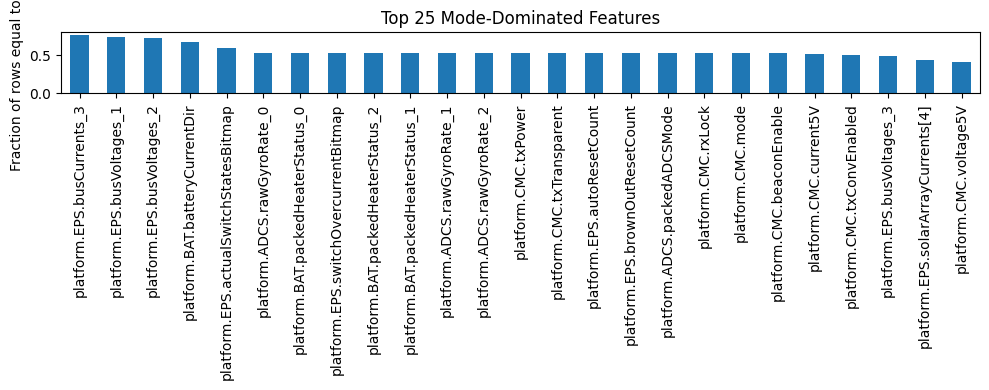

In [5]:
# ---- 4) Mode (most frequent value) dominance (detect flatlines/defaults) ----
num_df = df.select_dtypes(include=[np.number]).copy()
num_df = num_df.drop(columns=[c for c in num_df.columns if "anomaly" in c.lower()], errors="ignore")

mode_row = num_df.mode(dropna=True)
if len(mode_row) > 0:
    modes = mode_row.iloc[0]
    dominance = {}
    for col in num_df.columns:
        m = modes[col]
        dominance[col] = (num_df[col] == m).mean()
    dominance = pd.Series(dominance).sort_values(ascending=False)

    print("\nTop 15 mode-dominated features (likely flatline/default):")
    print(dominance.head(15))

    plt.figure(figsize=(10,4))
    dominance.head(25).plot(kind="bar")
    plt.title("Top 25 Mode-Dominated Features")
    plt.ylabel("Fraction of rows equal to mode")
    plt.tight_layout()
    plt.show()



In [6]:
def tag_flight_anomalies(row):
    # Flight Anomaly 1: All EPS parameters go to 0 [cite: 257]
    # Flight Anomaly 2: Battery Voltage drops below 7.5V (~830 units) [cite: 261]
    # Flight Anomaly 3: Uptime resets to 0 [cite: 263]

    # Check Anomaly 2 (Low Battery)
    if row['platform.EPS.busVoltages_0'] < 850: # approx 830 units
        return 1

    # Check Anomaly 3 (Uptime Reset)
    if row['core.OBT.uptime'] == 0:
        return 1

    return 0

df_tvac['Anomaly_Bin'] = df_tvac.apply(tag_tvac_anomalies, axis=1)
df_flight['Anomaly_Bin'] = df_flight.apply(tag_flight_anomalies, axis=1)

print("TVAC Anomalies Found:", df_tvac['Anomaly_Bin'].sum())
print("Flight Test Anomalies Found:", df_flight['Anomaly_Bin'].sum())

TVAC Anomalies Found: 484
Flight Test Anomalies Found: 1047



Time-like columns: ['OBT', 'core.OBT.uptime', 'platform.obc.GPS.LastGpsTimeLog', 'platform.obc.GPS.UpdateGpsTimeLog_1', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'payload.GMOD.DP_CPLDTimeoutCounter', 'param readonly uint32 lastSvUpdate', 'param readonly uint16 successfulSvUpdates']

Using time column: OBT
Time range: 4542903.0 to 6279414.0


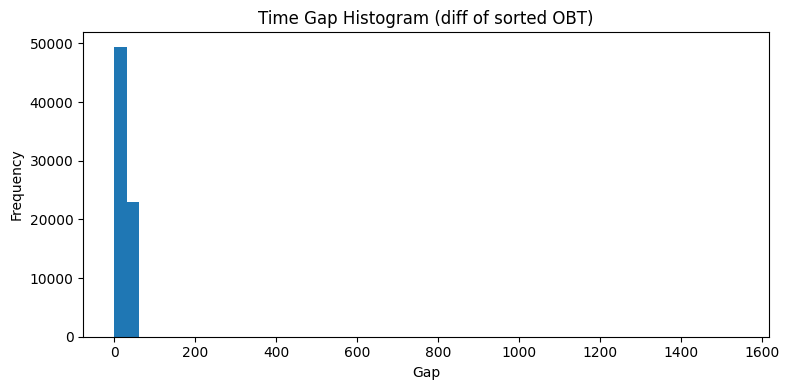

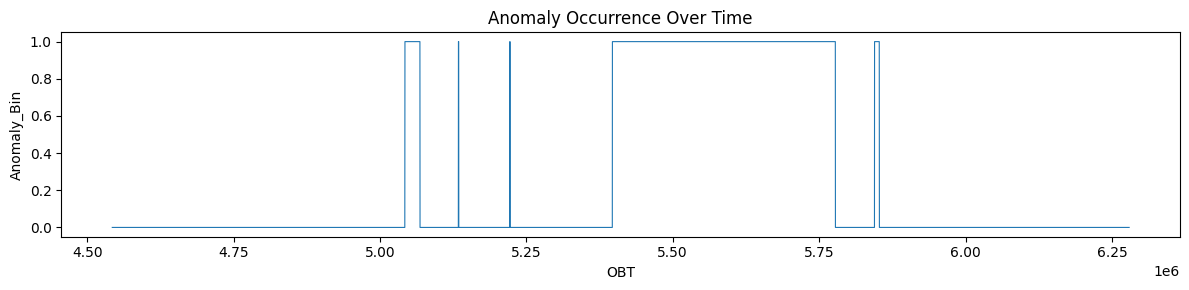

In [7]:
# ---- 8) Time/OBT analysis (sampling gaps + anomalies over time) ----
time_candidates = [c for c in df.columns if any(k in c.lower() for k in ["obt", "time", "timestamp", "date"])]
tcol = time_candidates[0] if time_candidates else None
print("\nTime-like columns:", time_candidates)

if tcol:
    t = pd.to_numeric(df[tcol], errors="coerce")
    valid = t.dropna()
    if len(valid) > 0:
        print(f"\nUsing time column: {tcol}")
        print("Time range:", float(valid.min()), "to", float(valid.max()))

        t_sorted = valid.sort_values().values
        if len(t_sorted) > 2:
            gaps = np.diff(t_sorted)
            plt.figure(figsize=(8,4))
            plt.hist(gaps, bins=50)
            plt.title(f"Time Gap Histogram (diff of sorted {tcol})")
            plt.xlabel("Gap")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

        # Anomaly over time plot
        plt.figure(figsize=(12,3))
        plt.plot(t, df["Anomaly_Bin"], linewidth=0.8)
        plt.title("Anomaly Occurrence Over Time")
        plt.xlabel(tcol)
        plt.ylabel("Anomaly_Bin")
        plt.tight_layout()
        plt.show()
else:
    print("\nNo time column found; skipping OBT/time plots.")



In [8]:
# ---- 5) Variance ranking (top 15) ----
variances = num_df.var(numeric_only=True).sort_values(ascending=False)
print("\nTop 15 columns by variance:\n", variances.head(15))



Top 15 columns by variance:
 platform.obc.GPS.LastGpsTimeLog         2.493919e+117
cdh.telemetry.DataPool.paramValid       3.076508e+105
core.EventDispatcher.lastEvent          2.303628e+105
payload.GMOD.DP_ErrMessages              2.634074e+61
platform.obc.GPS.UpdateGpsTimeLog_0      4.570970e+18
platform.obc.GPS.UpdateGpsTimeLog_1      1.211833e+18
payload.EMOD.DP_LastPageAddr             6.031031e+13
payload.GMOD.DP_LastPageSumAddr          5.981970e+13
payload.GMOD.DP_LastPage16Addr           3.371696e+13
param readonly uint32 lastSvUpdate       7.286183e+12
OBT                                      2.563289e+11
core.OBT.uptime                          2.494049e+10
platform.CMC.current5V                   2.263326e+09
payload.GMOD.DP_SegFaultCount            9.181815e+08
payload.GMOD.DP_NonCorrBitErrorCount     9.181815e+08
dtype: float64


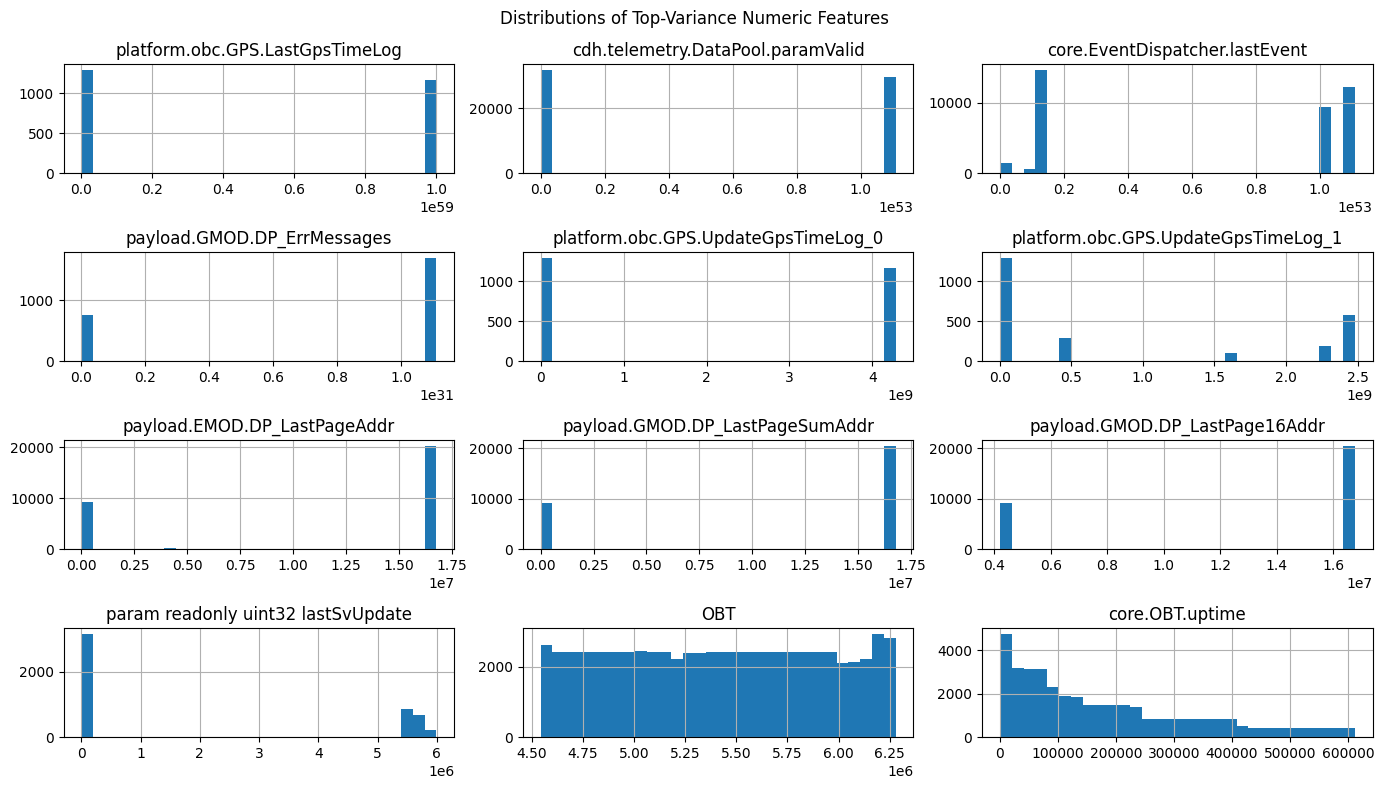

In [9]:
# ---- 6) Distributions of top-variance features ----
top_var_cols = variances.head(12).index.tolist()
num_df[top_var_cols].hist(figsize=(14,8), bins=30)
plt.suptitle("Distributions of Top-Variance Numeric Features")
plt.tight_layout()
plt.show()


Normal vs Anomaly distribution features: ['platform.obc.GPS.LastGpsTimeLog', 'cdh.telemetry.DataPool.paramValid', 'core.EventDispatcher.lastEvent', 'payload.GMOD.DP_ErrMessages', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'platform.obc.GPS.UpdateGpsTimeLog_1']


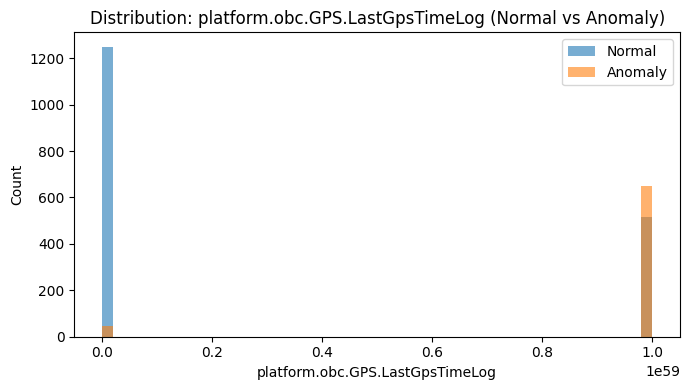

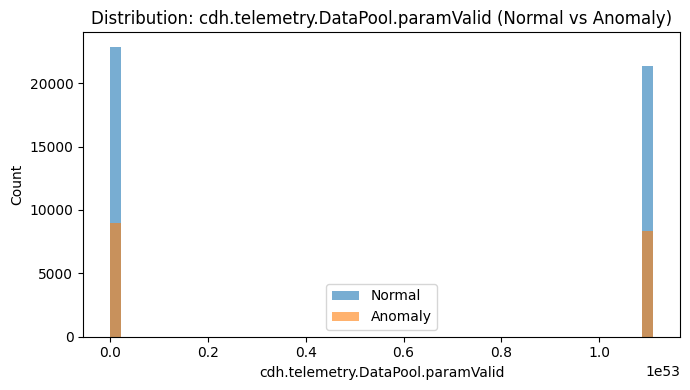

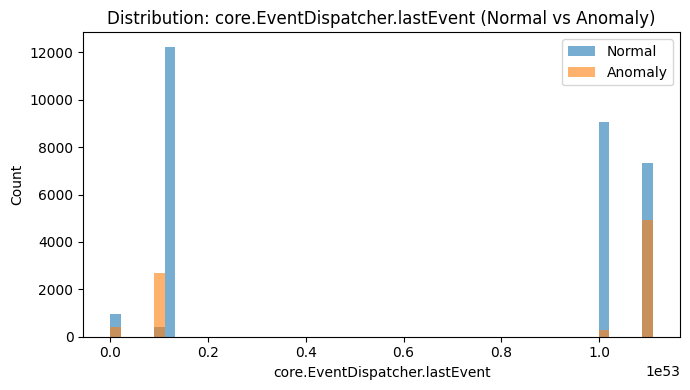

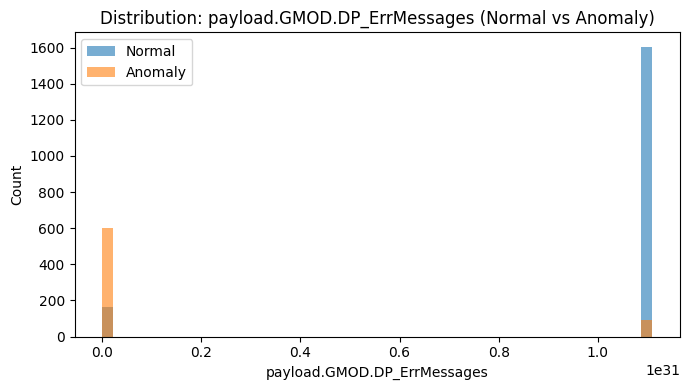

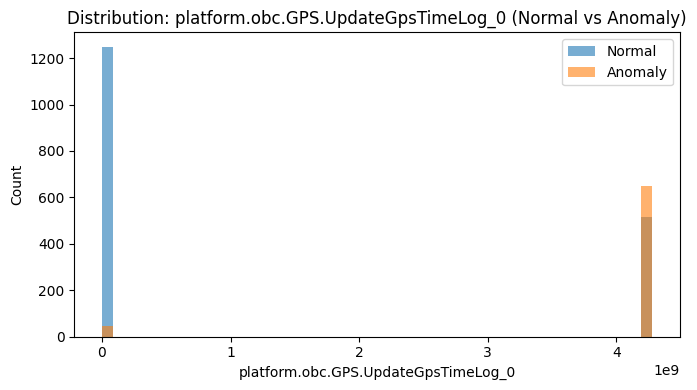

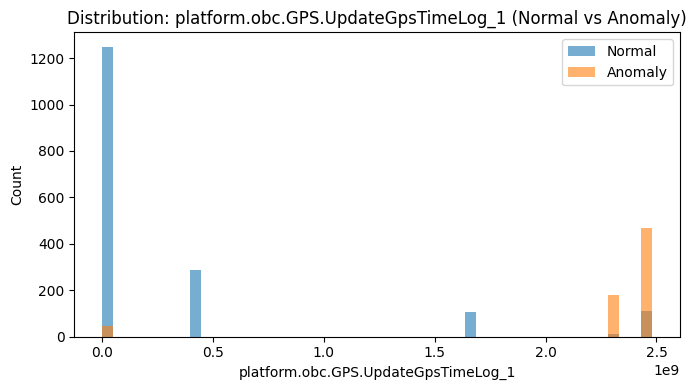

In [10]:
# ---- 10) Normal vs Anomaly feature distributions (top 6 features) ----
normal = df[df["Anomaly_Bin"] == 0]
anom = df[df["Anomaly_Bin"] == 1]

top6 = variances.head(6).index.tolist()
print("\nNormal vs Anomaly distribution features:", top6)

for col in top6:
    plt.figure(figsize=(7,4))
    plt.hist(normal[col].dropna(), bins=50, alpha=0.6, label="Normal")
    plt.hist(anom[col].dropna(), bins=50, alpha=0.6, label="Anomaly")
    plt.title(f"Distribution: {col} (Normal vs Anomaly)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

###For TVAC

In [11]:
df = pd.read_csv("/content/drive/MyDrive/tvac_dataset.csv")

print("Loaded TVAC dataset")
print("Shape:", df.shape)
print("\nDtype counts:\n", df.dtypes.value_counts())

Loaded TVAC dataset
Shape: (61109, 257)

Dtype counts:
 float64    253
int64        4
Name: count, dtype: int64



Anomaly columns: ['Anomaly_2', 'Anomaly_1', 'Anomaly_Bin']

Anomaly_Bin distribution:
 Anomaly_Bin
0    57583
1     3526
Name: count, dtype: int64


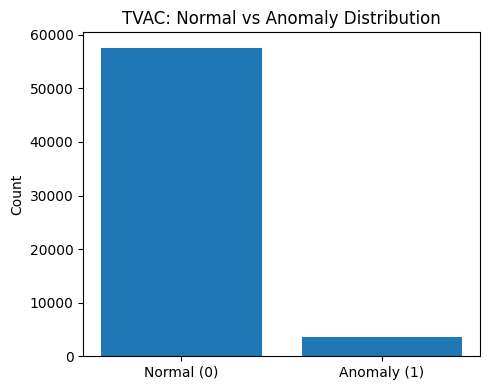

In [12]:
# ---- 1) Detect anomaly columns & build Anomaly_Bin ----
anomaly_cols = [c for c in df.columns if c.lower().startswith("anomaly_")]
print("\nAnomaly columns:", anomaly_cols)

for c in anomaly_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["Anomaly_Bin"] = (df[anomaly_cols].sum(axis=1) > 0).astype(int)

print("\nAnomaly_Bin distribution:\n", df["Anomaly_Bin"].value_counts())

plt.figure(figsize=(5,4))
counts = df["Anomaly_Bin"].value_counts().sort_index()
plt.bar(["Normal (0)", "Anomaly (1)"], counts.values)
plt.title("TVAC: Normal vs Anomaly Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [13]:
#Numeric features only
num_df = df.select_dtypes(include=[np.number]).copy()
num_df = num_df.drop(columns=[c for c in num_df.columns if "anomaly" in c.lower()],
                     errors="ignore")

print("\nNumeric features:", num_df.shape[1])



Numeric features: 254



Top 15 mode-dominated features:
platform.EPS.busCurrents_3              0.860512
platform.EPS.busVoltages_1              0.799522
platform.EPS.busVoltages_2              0.772767
platform.BAT.batteryCurrentDir          0.745308
platform.EPS.busVoltages_3              0.492955
platform.ADCS.rawGyroRate_1             0.483939
platform.EPS.switchOvercurrentBitmap    0.483939
platform.ADCS.rawGyroRate_2             0.483939
platform.ADCS.rawGyroRate_0             0.483939
platform.CMC.txConvEnabled              0.483939
platform.CMC.txPower                    0.483939
platform.CMC.txTransparent              0.483939
platform.EPS.autoResetCount             0.483873
platform.BAT.packedHeaterStatus_2       0.478538
platform.ADCS.packedADCSMode            0.474169
dtype: float64


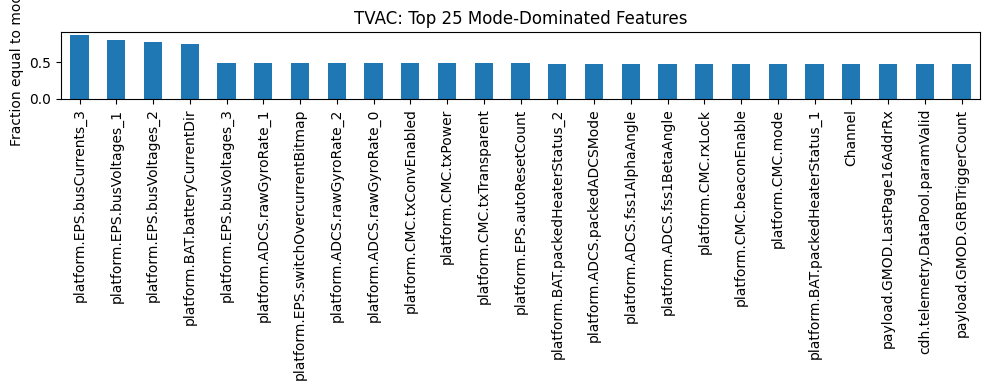

In [14]:
# ---- 4) Mode dominance (flatline / default sensors) ----
mode_row = num_df.mode(dropna=True)
if len(mode_row) > 0:
    modes = mode_row.iloc[0]
    dominance = (num_df == modes).mean().sort_values(ascending=False)

    print("\nTop 15 mode-dominated features:")
    print(dominance.head(15))

    plt.figure(figsize=(10,4))
    dominance.head(25).plot(kind="bar")
    plt.title("TVAC: Top 25 Mode-Dominated Features")
    plt.ylabel("Fraction equal to mode")
    plt.tight_layout()
    plt.show()

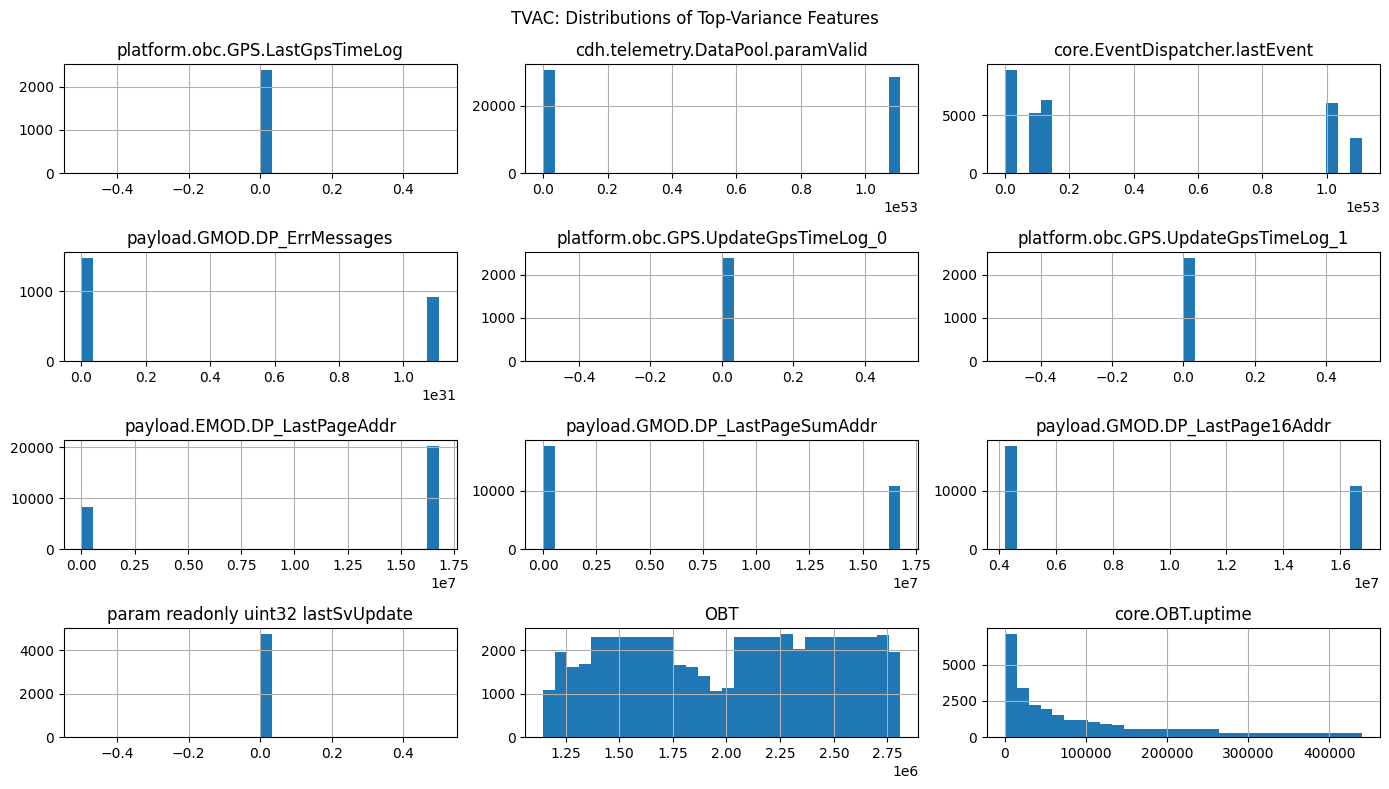

In [15]:
top_var_cols = variances.head(12).index.tolist()
num_df[top_var_cols].hist(figsize=(14,8), bins=30)
plt.suptitle("TVAC: Distributions of Top-Variance Features")
plt.tight_layout()
plt.show()


Time-like columns: ['OBT', 'core.OBT.uptime', 'platform.obc.GPS.LastGpsTimeLog', 'platform.obc.GPS.UpdateGpsTimeLog_1', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'payload.GMOD.DP_CPLDTimeoutCounter', 'param readonly uint32 lastSvUpdate', 'param readonly uint16 successfulSvUpdates']
Time range: 1145695.0 to 2810501.0


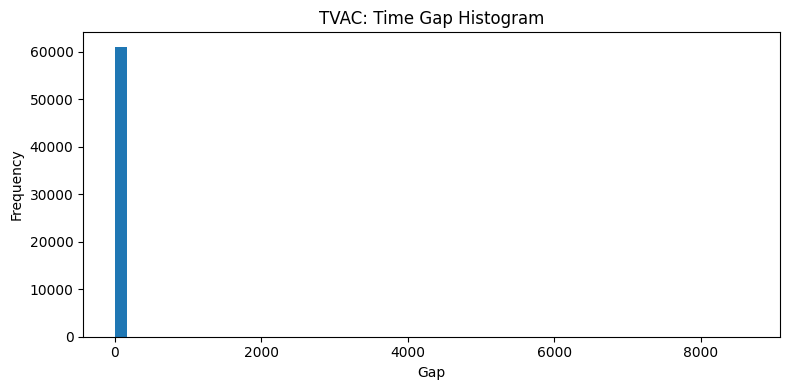

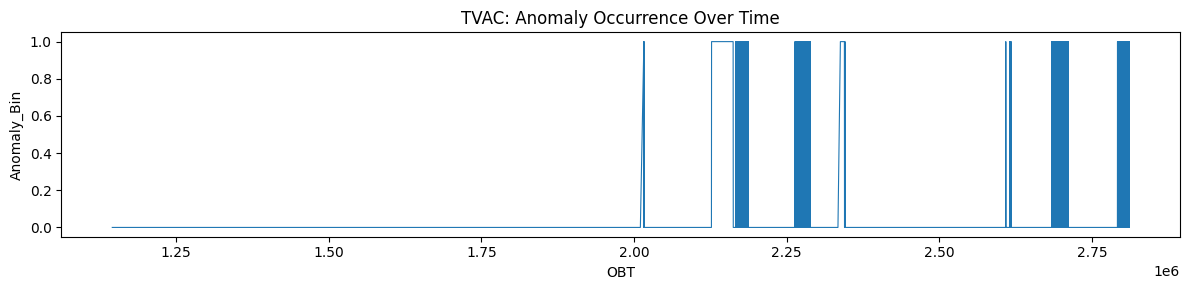

In [16]:
# Time / OBT analysis ----
time_candidates = [c for c in df.columns if any(k in c.lower() for k in ["obt", "time", "timestamp", "date"])]
print("\nTime-like columns:", time_candidates)

if time_candidates:
    tcol = time_candidates[0]
    t = pd.to_numeric(df[tcol], errors="coerce")
    valid = t.dropna()

    if len(valid) > 0:
        print("Time range:", float(valid.min()), "to", float(valid.max()))

        gaps = np.diff(valid.sort_values().values)
        plt.figure(figsize=(8,4))
        plt.hist(gaps, bins=50)
        plt.title("TVAC: Time Gap Histogram")
        plt.xlabel("Gap")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12,3))
        plt.plot(t, df["Anomaly_Bin"], linewidth=0.8)
        plt.title("TVAC: Anomaly Occurrence Over Time")
        plt.xlabel(tcol)
        plt.ylabel("Anomaly_Bin")
        plt.tight_layout()
        plt.show()




Normal vs Anomaly comparison features: ['platform.obc.GPS.LastGpsTimeLog', 'cdh.telemetry.DataPool.paramValid', 'core.EventDispatcher.lastEvent', 'payload.GMOD.DP_ErrMessages', 'platform.obc.GPS.UpdateGpsTimeLog_0', 'platform.obc.GPS.UpdateGpsTimeLog_1']


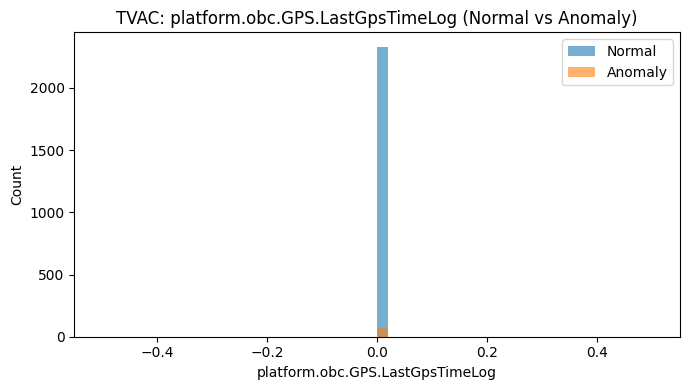

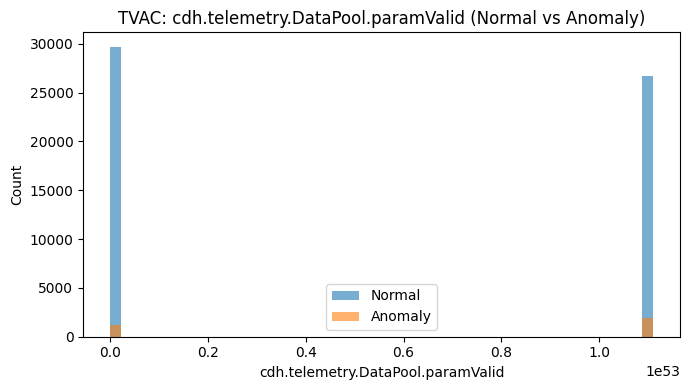

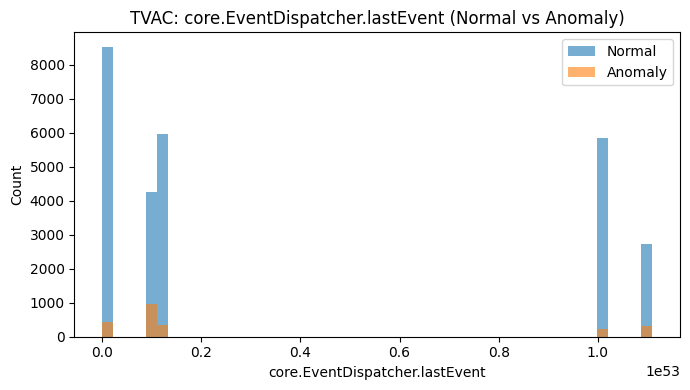

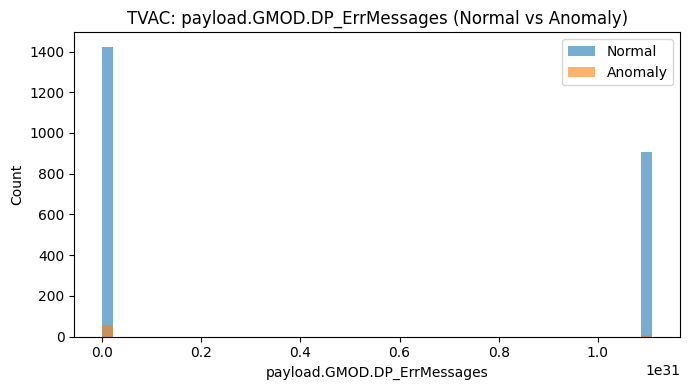

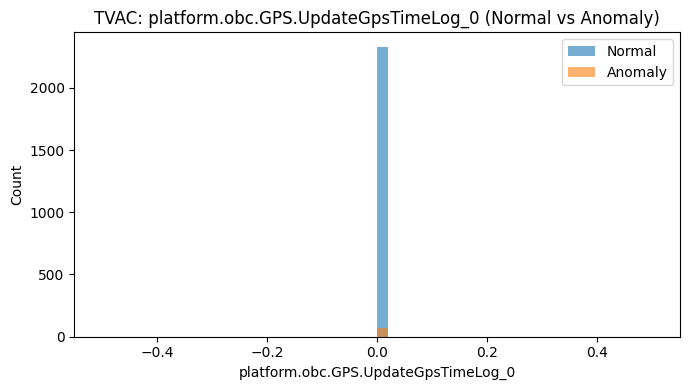

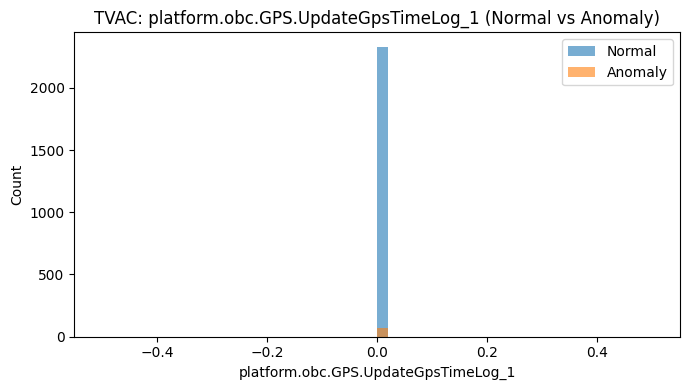

In [17]:
#Normal vs Anomaly feature comparison ----
normal = df[df["Anomaly_Bin"] == 0]
anom = df[df["Anomaly_Bin"] == 1]

top6 = variances.head(6).index.tolist()
print("\nNormal vs Anomaly comparison features:", top6)

for col in top6:
    plt.figure(figsize=(7,4))
    plt.hist(normal[col].dropna(), bins=50, alpha=0.6, label="Normal")
    plt.hist(anom[col].dropna(), bins=50, alpha=0.6, label="Anomaly")
    plt.title(f"TVAC: {col} (Normal vs Anomaly)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

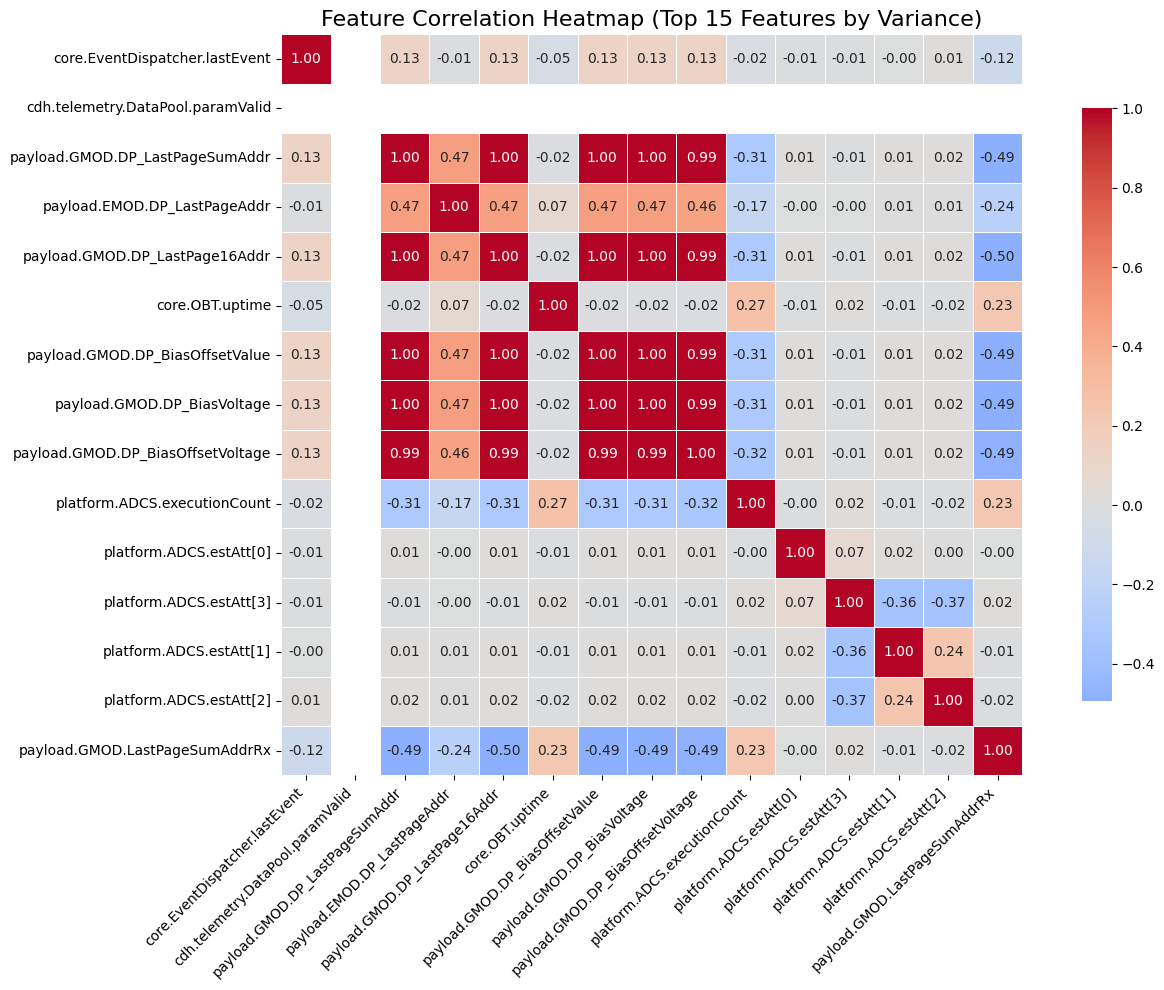

In [34]:
df_ch = df_tvac[df_tvac['Channel'] == 15].copy()

# Drop metadata columns to isolate features
meta_cols = ['OBT', 'Channel', 'Row_ID', 'Unnamed: 0']
X = df_ch.drop(columns=[c for c in meta_cols if c in df_ch.columns])

# Strict Cleaning: Force numeric, drop NaNs, drop constants
X = X.apply(pd.to_numeric, errors='coerce')
X_clean = X.dropna(axis=1, how='any')
X_clean = X_clean.loc[:, X_clean.std() > 0]

top_variance_cols = X_clean.var().nlargest(15).index
X_subset = X_clean[top_variance_cols]

# Calculate Correlation Matrix
corr_matrix = X_subset.corr()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,       # <--- This turns on the values
    fmt=".2f",        # Format to 2 decimal places
    cmap='coolwarm',  # Red = Positive corr, Blue = Negative corr
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap (Top 15 Features by Variance)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


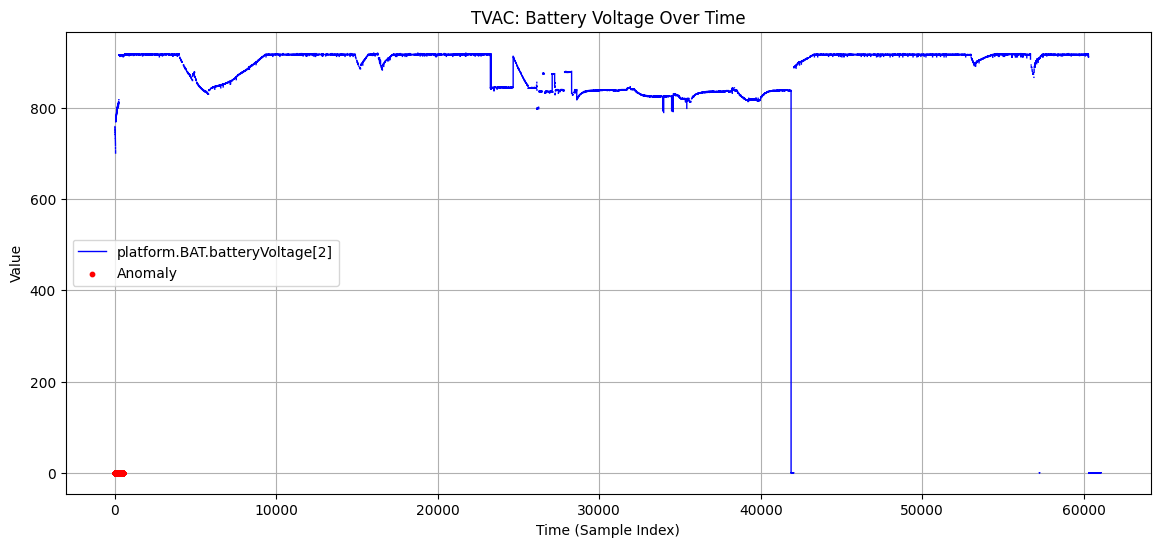

In [19]:
#Time Series Anomaly Plot

def plot_time_series(df, param, title):
    plt.figure(figsize=(14, 6))
    # Reset index to use as time proxy if OBT is not datetime
    plt.plot(df.reset_index().index, df[param], label=param, color='blue', linewidth=1)

    # Highlight Anomalies
    anomalies = df[df['Anomaly_Bin'] == 1].reset_index()
    plt.scatter(anomalies.index, anomalies[param], color='red', label='Anomaly', s=10, zorder=5)

    plt.title(title)
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Battery Voltage for TVAC (Key indicator for Anomaly 1)
if 'platform.BAT.batteryVoltage[2]' in df_tvac.columns:
    plot_time_series(df_tvac, 'platform.BAT.batteryVoltage[2]', "TVAC: Battery Voltage Over Time")
elif 'platform.EPS.busVoltages_0' in df_flight.columns:
    # Fallback to Flight Test Bus Voltage if TVAC col missing
    plot_time_series(df_flight, 'platform.EPS.busVoltages_0', "Flight Test: Bus Voltage Over Time")

/tmp/ipython-input-1197350994.py:21: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(fn)


Found 251 data gaps. Largest gap: 253905.0 units


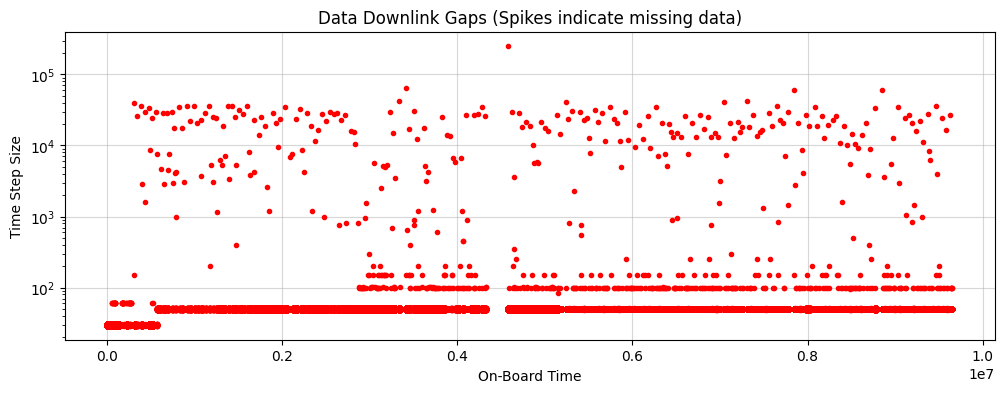

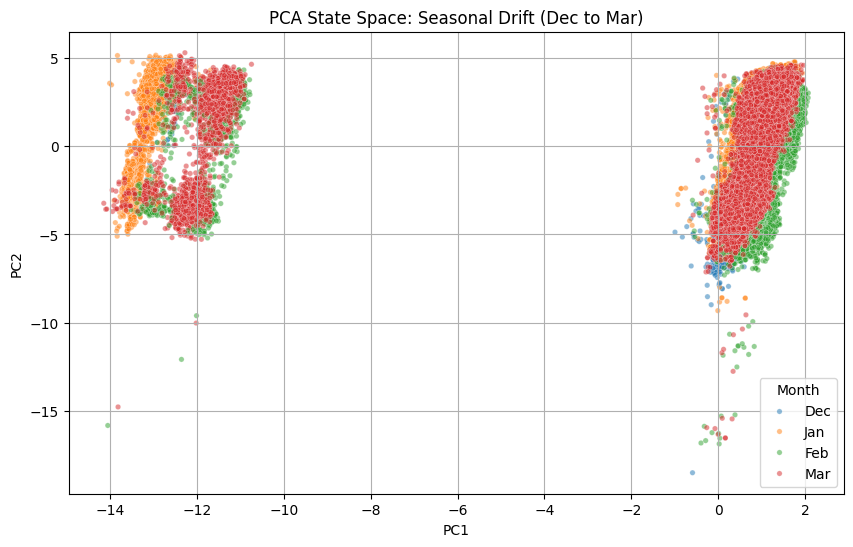

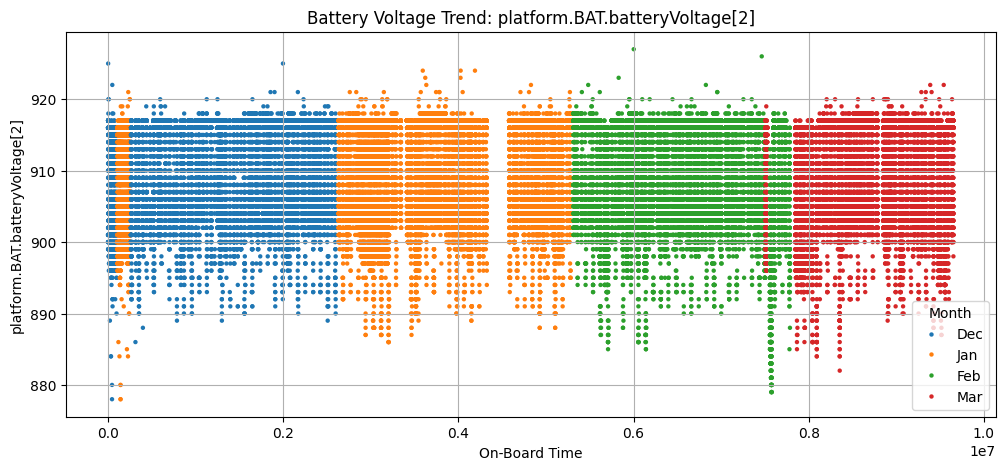

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==========================================
# 1. Load & Combine Flight Data
# ==========================================
files = {
    'Dec':'/content/drive/MyDrive/channel_15Dec.csv',
    'Jan':'/content/drive/MyDrive/channel_15_Jan.csv',
    'Feb':'/content/drive/MyDrive/channel_15feb.csv',
    'Mar':'/content/drive/MyDrive/channel_15_Mar.csv',
}

dfs = []
for month, fn in files.items():
    try:
        tmp = pd.read_csv(fn)
        tmp['Month'] = month
        dfs.append(tmp)
    except FileNotFoundError:
        print(f"Warning: {fn} not found.")

if not dfs:
    raise ValueError("No data loaded!")

df = pd.concat(dfs, ignore_index=True)

# ==========================================
# 2. Gap Analysis (Critical for Flight Data)
# ==========================================
# Identify the OBT (Time) column
obt_col = [c for c in df.columns if 'uptime' in c or 'OBT' in c][0]
df['OBT_Clean'] = pd.to_numeric(df[obt_col], errors='coerce')

# Sort by time to find gaps
df = df.sort_values('OBT_Clean')
df['Time_Diff'] = df['OBT_Clean'].diff()

# Define a "Gap" as > 1000 units (adjust based on your specific OBT unit)
gaps = df[df['Time_Diff'] > 1000]
print(f"Found {len(gaps)} data gaps. Largest gap: {df['Time_Diff'].max()} units")

# Plot Gaps
plt.figure(figsize=(12, 4))
plt.plot(df['OBT_Clean'], df['Time_Diff'], '.', color='red', label='Time Delta')
plt.title("Data Downlink Gaps (Spikes indicate missing data)")
plt.xlabel("On-Board Time")
plt.ylabel("Time Step Size")
plt.yscale('log')
plt.grid(True, alpha=0.5)
plt.show()

# Select numeric features only
X = df.select_dtypes(include=[np.number]).copy()

# Drop metadata that confuses PCA
drop_cols = ['OBT', 'Channel', 'Row', 'Unnamed', 'Diff', 'uptime', 'Clean']
X = X.drop(columns=[c for c in X.columns if any(k in c for k in drop_cols)])

# Cleaning: Drop infinite, massive values (timestamps), and constants
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=1, thresh=len(X)*0.5) # Drop mostly-empty cols
X = X.fillna(X.mean())                  # Fill remaining NaNs
X = X.loc[:, X.mean() < 1e10]           # Drop timestamp-like large values
X = X.loc[:, X.std() > 0]               # Drop constant cols

# Run PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
comps = pca.fit_transform(X_scaled)

# Plot
pca_df = pd.DataFrame(comps, columns=['PC1', 'PC2'])
pca_df['Month'] = df['Month'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Month', alpha=0.5, s=15)
plt.title("PCA State Space: Seasonal Drift (Dec to Mar)")
plt.grid(True)
plt.show()

# ==========================================
# 4. Battery Voltage Trend
# ==========================================
volt_col = [c for c in df.columns if 'batteryVoltage' in c][0]

plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='OBT_Clean', y=volt_col, hue='Month', s=10, linewidth=0)
plt.title(f"Battery Voltage Trend: {volt_col}")
plt.xlabel("On-Board Time")
plt.grid(True)
plt.show()

###1. Sawtooth Wave:

The Insight: This captures the Orbital Period (approx. 90 minutes for LEO satellites).

Rising Edge: The satellite is in Sunlight. The Solar Panels are generating power, charging the battery.

Falling Edge: The satellite is in Eclipse (Earth's shadow). The Solar Panels are off, and the battery is discharging to power the bus.

Conclusion: The power system is functioning correctly. The battery is successfully cycling thousands of times without failure.

###2. Seasonal Drift (The "Beta Angle" Effect)


The Insight: This confirms Concept Drift due to the changing Beta Angle.

The angle of the sun relative to the orbit plane changes with the seasons.

December: Might have had longer eclipses (deeper discharge, lower average voltage).

March: Might have shorter eclipses (shallower discharge, higher average voltage)

###3. The "Ceiling" Stability (Battery Health)
What to look for: Look at the top edge of the data across all 4 months. It should be a flat, horizontal line (around 925 raw units or ~8.2V).

  The Insight: The battery is consistently reaching "Full Charge."

  Conclusion: There is no significant battery degradation. If the top edge were sloping downwards from Dec to Mar, it would mean the battery is losing its ability to hold a full charge (like an old phone). Since it's flat, the hardware is healthy.

### Final Conclusion:
The longitudinal analysis of battery voltage from December to March reveals a stable charge-discharge cycle consistent with nominal orbital operations. While the maximum charge voltage remains constant (indicating good battery health), a seasonal drift in the depth-of-discharge is observed, likely attributed to varying beta angles and eclipse durations. This seasonal variance confirms the necessity for adaptive machine learning models that can distinguish between environmental drift and component failure.

Data Loaded.
Common valid columns: 53


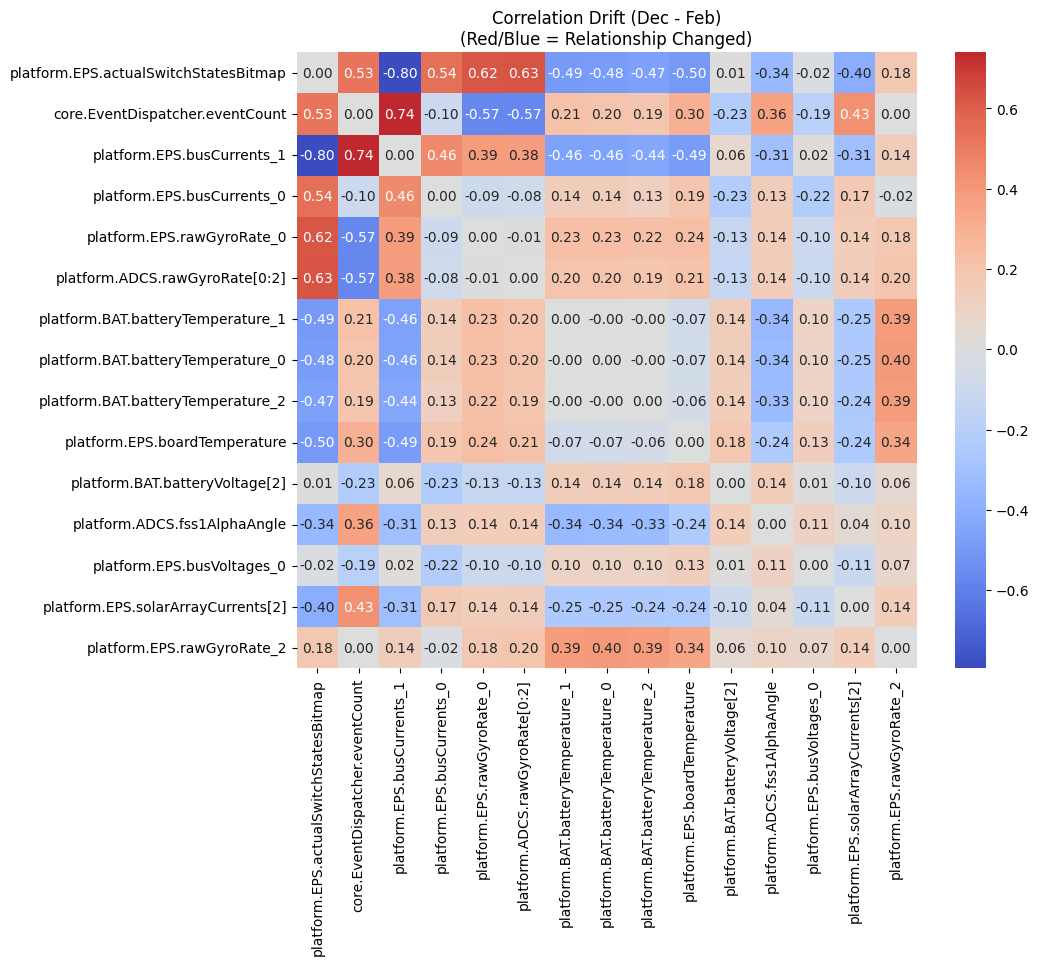

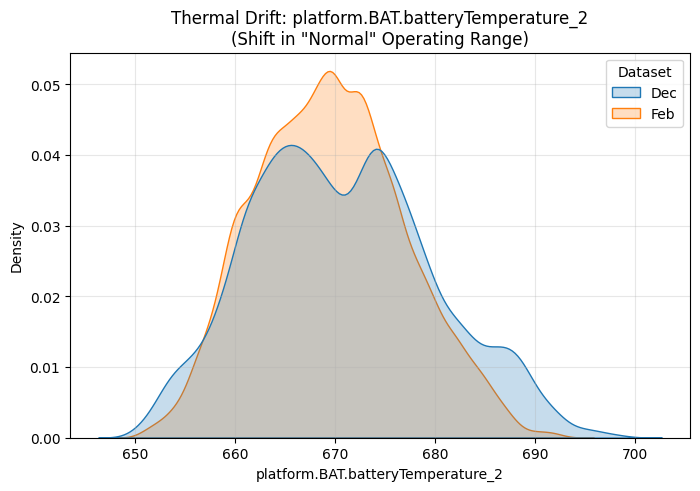

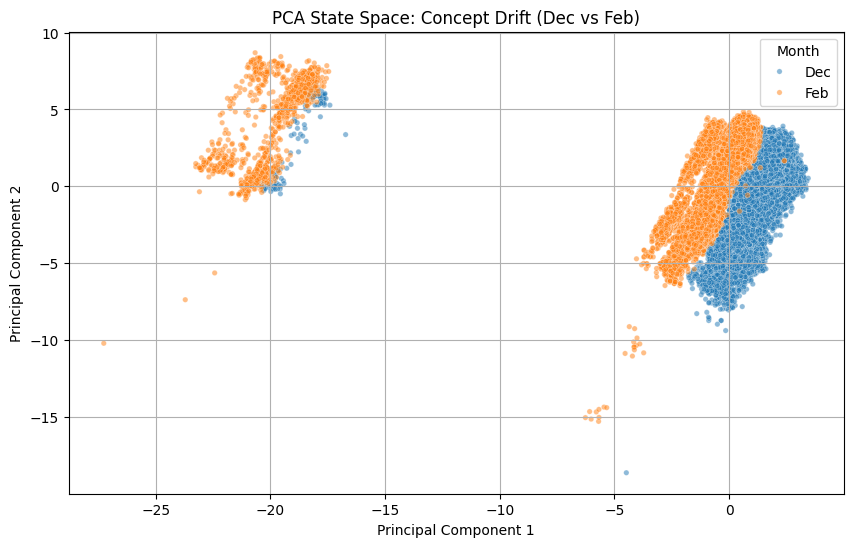

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==========================================
# 1. Load Data
# ==========================================
try:
    df_dec = pd.read_csv('/content/drive/MyDrive/channel_15Dec.csv')
    df_feb = pd.read_csv('/content/drive/MyDrive/channel_15feb.csv')

    # Tag them
    df_dec['Dataset'] = 'Dec'
    df_feb['Dataset'] = 'Feb'

    # Combine for global analysis
    df_flight = pd.concat([df_dec, df_feb], ignore_index=True)
    print("Data Loaded.")
except FileNotFoundError:
    print("Error: Files not found. Please upload 'channel_15Dec.csv' and 'channel_15feb.csv'.")

# ==========================================
# 2. Robust Cleaning Helper
# ==========================================
def robust_clean(df):
    # Select numeric columns
    X = df.select_dtypes(include=[np.number]).copy()

    # Drop known metadata (OBT, RowID, etc)
    drop_patterns = ['OBT', 'uptime', 'Row', 'Unnamed', 'Diff', 'Channel']
    cols_to_drop = [c for c in X.columns if any(p in c for p in drop_patterns)]
    X = X.drop(columns=cols_to_drop)

    # Force numeric & Coerce errors
    X = X.apply(pd.to_numeric, errors='coerce')

    # Drop columns with ANY NaNs (Strict approach for correlation)
    X = X.dropna(axis=1, how='any')

    # Drop constant columns (std=0)
    X = X.loc[:, X.std() > 0]

    # Drop columns with extreme values (timestamps usually > 1e6)
    X = X.loc[:, X.mean() < 1e6]

    return X

# Clean datasets independently
X_dec = robust_clean(df_dec)
X_feb = robust_clean(df_feb)

# Find common columns between months
common_cols = X_dec.columns.intersection(X_feb.columns)
print(f"Common valid columns: {len(common_cols)}")

# ==========================================
# 3. Insight 1: Correlation Drift (Heatmap)
# ==========================================
if len(common_cols) > 0:
    # Calculate matrices
    corr_dec = X_dec[common_cols].corr()
    corr_feb = X_feb[common_cols].corr()

    # Calculate Difference (Drift)
    corr_diff = corr_feb - corr_dec

    # Find top 15 features that changed the most
    change_magnitude = corr_diff.abs().mean().sort_values(ascending=False).head(15)
    top_changed = change_magnitude.index

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_diff.loc[top_changed, top_changed],
        cmap='coolwarm', center=0, annot=True, fmt=".2f"
    )
    plt.title('Correlation Drift (Dec - Feb)\n(Red/Blue = Relationship Changed)')
    plt.show()

# ==========================================
# 4. Insight 2: Distribution Shift (KDE)
# ==========================================
# Find a temperature column in common columns
temp_cols = [c for c in common_cols if 'Temperature' in c]

if temp_cols:
    target = temp_cols[0]
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df_flight, x=target, hue='Dataset', fill=True, common_norm=False)
    plt.title(f'Thermal Drift: {target}\n(Shift in "Normal" Operating Range)')
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 5. Insight 3: PCA State Space Drift
# ==========================================
# Use combined data for PCA
X_combined = robust_clean(df_flight)

if not X_combined.empty:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    pca = PCA(n_components=2)
    comps = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(comps, columns=['PC1', 'PC2'])
    pca_df['Month'] = df_flight['Dataset'].values

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Month', alpha=0.5, s=15)
    plt.title('PCA State Space: Concept Drift (Dec vs Feb)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

###Power switching vs load behavior changed significantly

Large drift between EPS switch state bitmap and bus currents (strong negative shift).

Meaning: the relationship between switch configuration and current draw changed.

Value: Indicates operational mode / load routing change, not random noise. Important for anomaly models — use month-wise baselines.

###Electrical load vs system activity relationship shifted

Event count vs bus current shows strong positive drift.

Meaning: system events in Feb are driving power usage differently than in Dec.

Value: Suggests different duty cycles or payload schedules — include event features in modeling.

###Attitude (gyro) vs power correlations drifted

Gyro rates vs EPS metrics show moderate drift.

Meaning: motion/control activity is no longer linked to power usage in the same way.

Value: Points to mission mode or maneuver frequency change — useful for mode segmentation.

###Battery temperature sensors remain internally stable

Battery temperature channels still strongly correlated with each other.

Meaning: sensor reliability is stable.

Value: Good reference feature group; drift elsewhere is behavioral, not sensor fault.

###Solar array current correlations shifted

Drift vs battery temp and bus current.

Meaning: charging pattern changed.

Value: Likely seasonal illumination / orbit effect — expected drift, should not be flagged as anomaly.

###Some voltage features show low drift

Bus voltage and battery voltage correlations mostly stable.

Value: Use as baseline anchor features for drift monitoring and normalization.

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
    f1_score, precision_score, recall_score, accuracy_score,
    average_precision_score, roc_curve)

BASE = r"E:\ML_Project_Dataset\EIRSAT-1 Dataset"

FLIGHTTEST_PATH = os.path.join(BASE, "Flight Test Data", "flighttest_dataset.csv")
TVAC_PATH       = os.path.join(BASE, "TVAC Test Data",  "tvac_dataset.csv")

def load_csv(path):
    return pd.read_csv(path, low_memory=False)

def build_anomaly_bin(df):
    df = df.copy()
    anomaly_cols = [c for c in df.columns if c.lower().startswith("anomaly_")]
    if anomaly_cols:
        for c in anomaly_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
        df["Anomaly_Bin"] = (df[anomaly_cols].sum(axis=1) > 0).astype(int)
    else:
        df["Anomaly_Bin"] = 0
    return df

def prepare_features(df, pca_variance=0.95):
    y = df["Anomaly_Bin"].values if "Anomaly_Bin" in df.columns else np.zeros(len(df))

    X = df.select_dtypes(include=[np.number]).copy()

    drop_cols = [c for c in X.columns
                 if c.lower().startswith("anomaly_")
                 or c == "Anomaly_Bin"
                 or any(k in c.lower() for k in ["obt","timestamp","uptime","row_id","unnamed"])]
    X = X.drop(columns=drop_cols, errors="ignore")
    X = X.loc[:, X.isna().mean() <= 0.95]
    X = X.loc[:, X.var() > 1e-12]

    feature_names = X.columns.tolist()
    X = X.fillna(X.median())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=pca_variance, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Raw features       : {len(feature_names)}")
    print(f"PCA components     : {X_pca.shape[1]}")
    print(f"Total samples      : {len(y)}")
    print(f"Anomaly rate       : {y.mean():.4f}")

    return X_pca, X_scaled, y, scaler, pca, feature_names

print("Loading Flight-Test...")
ft = build_anomaly_bin(load_csv(FLIGHTTEST_PATH))
X_ft, X_ft_sc, y_ft, scaler_ft, pca_ft, feat_ft = prepare_features(ft)

print("\nLoading TVAC...")
tv = build_anomaly_bin(load_csv(TVAC_PATH))
X_tv, X_tv_sc, y_tv, scaler_tv, pca_tv, feat_tv = prepare_features(tv)

Loading Flight-Test...
Raw features       : 160
PCA components     : 71
Total samples      : 72390
Anomaly rate       : 0.2395

Loading TVAC...
Raw features       : 160
PCA components     : 66
Total samples      : 61109
Anomaly rate       : 0.0577


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, precision_score, recall_score, accuracy_score,
    average_precision_score, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)

ALL_RESULTS = []

def evaluate_model(model, X, y, model_name, dataset_name, test_size=0.2):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        raw    = model.decision_function(X_test)
        y_prob = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred, zero_division=0)
    rec     = recall_score(y_test, y_pred, zero_division=0)
    f1      = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc  = average_precision_score(y_test, y_prob)

    print(f"\n{'='*55}")
    print(f"  {model_name}  |  {dataset_name}")
    print(f"{'='*55}")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print(f"  ROC-AUC   : {roc_auc:.4f}")
    print(f"  PR-AUC    : {pr_auc:.4f}")
    print()
    print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

    ALL_RESULTS.append({
        "Model"    : model_name,
        "Dataset"  : dataset_name,
        "Accuracy" : round(acc, 4),
        "Precision": round(prec, 4),
        "Recall"   : round(rec, 4),
        "F1-Score" : round(f1, 4),
        "ROC-AUC"  : round(roc_auc, 4),
        "PR-AUC"   : round(pr_auc, 4),
    })

    # Plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
        display_labels=["Normal", "Anomaly"]).plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title("Confusion Matrix")

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC={roc_auc:.3f}")
    axes[1].plot([0,1],[0,1], "k--", lw=1)
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    prec_c, rec_c, _ = precision_recall_curve(y_test, y_prob)
    axes[2].plot(rec_c, prec_c, color="steelblue", lw=2, label=f"AP={pr_auc:.3f}")
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title("PR Curve")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle(f"{model_name} — {dataset_name}", fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return model, y_pred, y_prob

Using Logistic Regression


  Logistic Regression  |  Flight-Test
  Accuracy  : 0.9266
  Precision : 0.7868
  Recall    : 0.9515
  F1-Score  : 0.8614
  ROC-AUC   : 0.9759
  PR-AUC    : 0.9410

              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95     11011
     Anomaly       0.79      0.95      0.86      3467

    accuracy                           0.93     14478
   macro avg       0.89      0.94      0.91     14478
weighted avg       0.94      0.93      0.93     14478



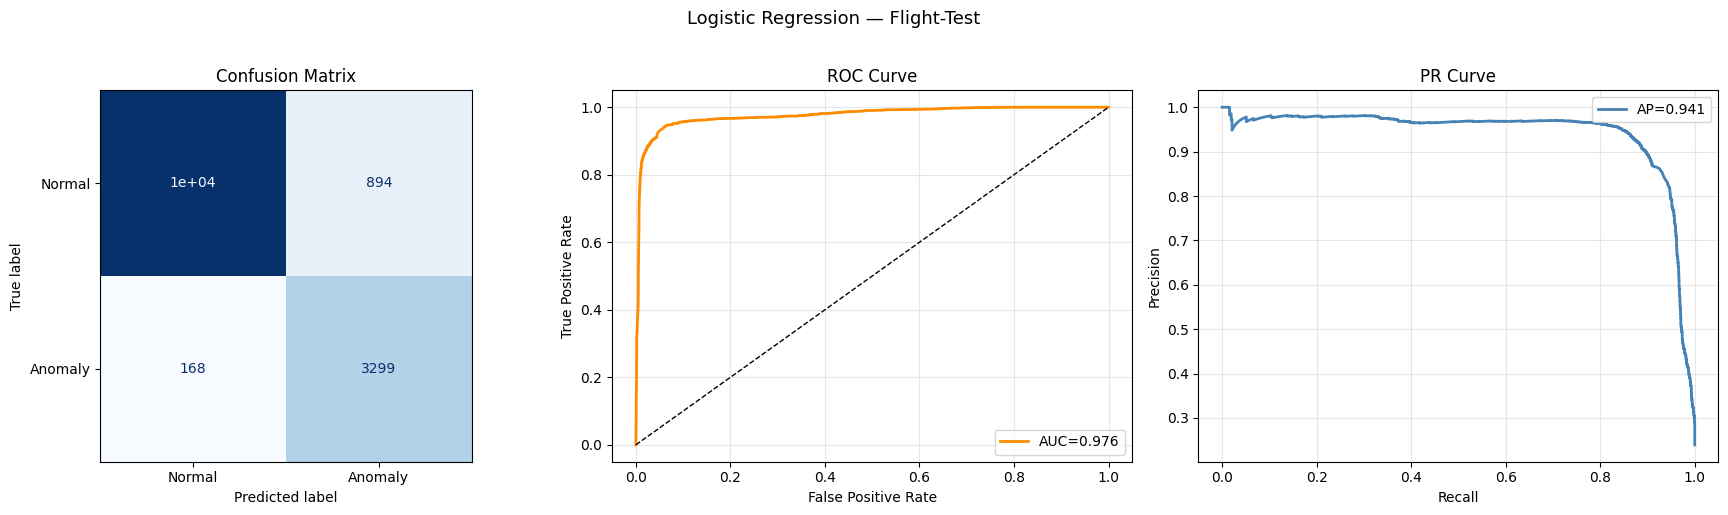


  Logistic Regression  |  TVAC
  Accuracy  : 0.9849
  Precision : 0.8002
  Recall    : 0.9830
  F1-Score  : 0.8822
  ROC-AUC   : 0.9972
  PR-AUC    : 0.9749

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     11517
     Anomaly       0.80      0.98      0.88       705

    accuracy                           0.98     12222
   macro avg       0.90      0.98      0.94     12222
weighted avg       0.99      0.98      0.99     12222



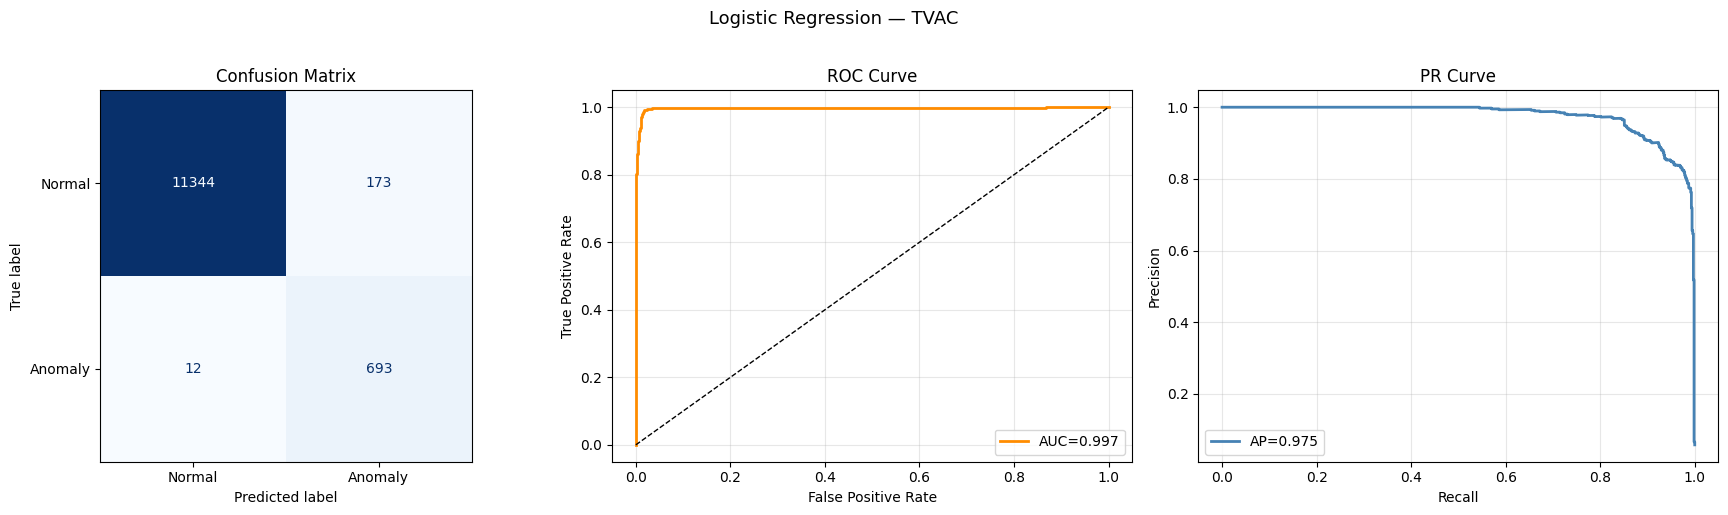

(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 array([0, 0, 0, ..., 0, 0, 0], shape=(12222,)),
 array([9.83452762e-05, 1.32402427e-03, 6.12056053e-04, ...,
        6.31074831e-03, 5.37081774e-04, 7.99957353e-05], shape=(12222,)))

In [17]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

lr = LogisticRegression(
    C=1.0,
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
evaluate_model(lr, X_ft, y_ft, "Logistic Regression", "Flight-Test")
evaluate_model(lr, X_tv, y_tv, "Logistic Regression", "TVAC")

Decision Tree Classifier


  Decision Tree  |  Flight-Test
  Accuracy  : 0.9600
  Precision : 0.9038
  Recall    : 0.9322
  F1-Score  : 0.9178
  ROC-AUC   : 0.9701
  PR-AUC    : 0.9465

              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97     11011
     Anomaly       0.90      0.93      0.92      3467

    accuracy                           0.96     14478
   macro avg       0.94      0.95      0.95     14478
weighted avg       0.96      0.96      0.96     14478



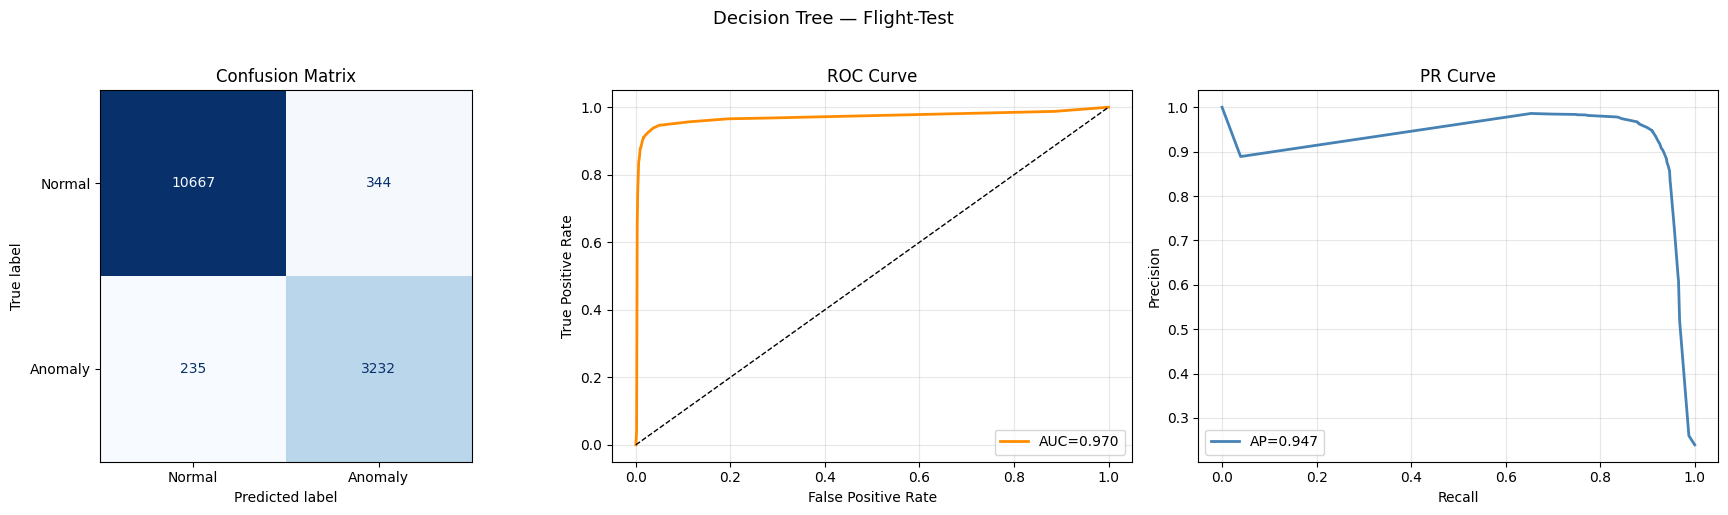


  Decision Tree  |  TVAC
  Accuracy  : 0.9912
  Precision : 0.8882
  Recall    : 0.9688
  F1-Score  : 0.9267
  ROC-AUC   : 0.9811
  PR-AUC    : 0.8815

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     11517
     Anomaly       0.89      0.97      0.93       705

    accuracy                           0.99     12222
   macro avg       0.94      0.98      0.96     12222
weighted avg       0.99      0.99      0.99     12222



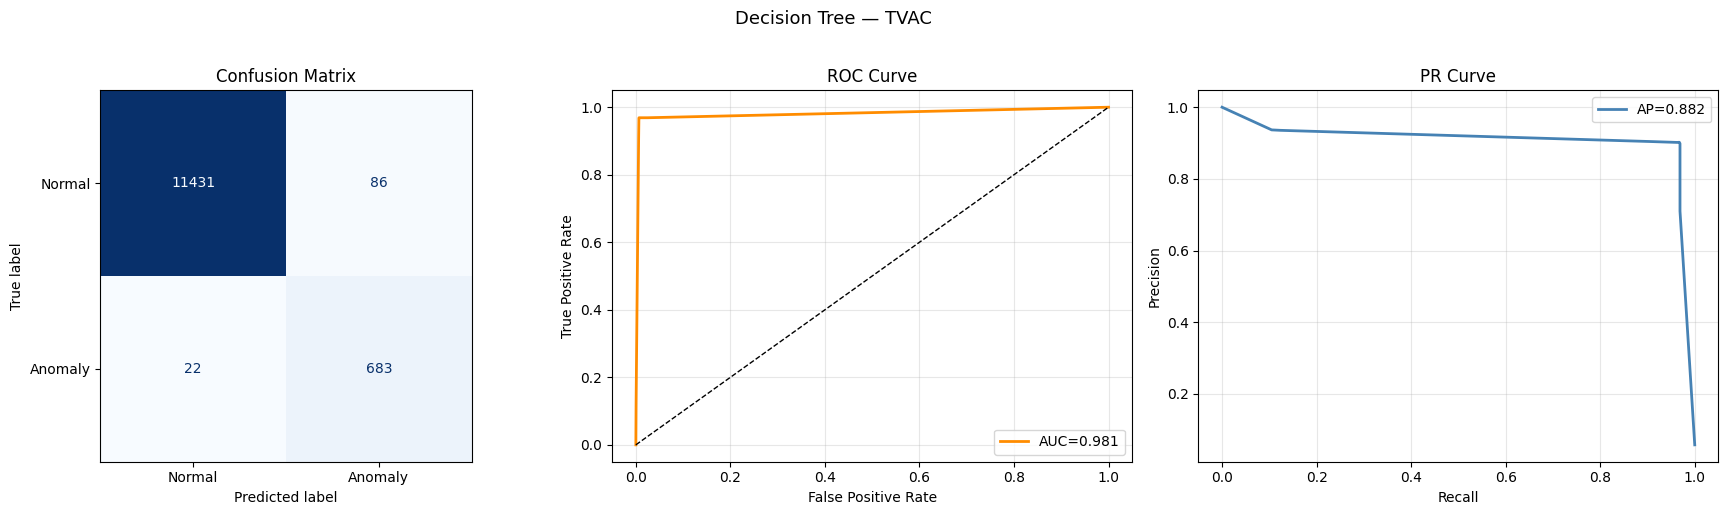

(DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42),
 array([0, 0, 0, ..., 0, 0, 0], shape=(12222,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(12222,)))

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=42)
evaluate_model(dt, X_ft, y_ft, "Decision Tree", "Flight-Test")
evaluate_model(dt, X_tv, y_tv, "Decision Tree", "TVAC")

Random Forest Classifier



  Random Forest  |  Flight-Test
  Accuracy  : 0.9744
  Precision : 0.9540
  Recall    : 0.9383
  F1-Score  : 0.9461
  ROC-AUC   : 0.9947
  PR-AUC    : 0.9870

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98     11011
     Anomaly       0.95      0.94      0.95      3467

    accuracy                           0.97     14478
   macro avg       0.97      0.96      0.96     14478
weighted avg       0.97      0.97      0.97     14478



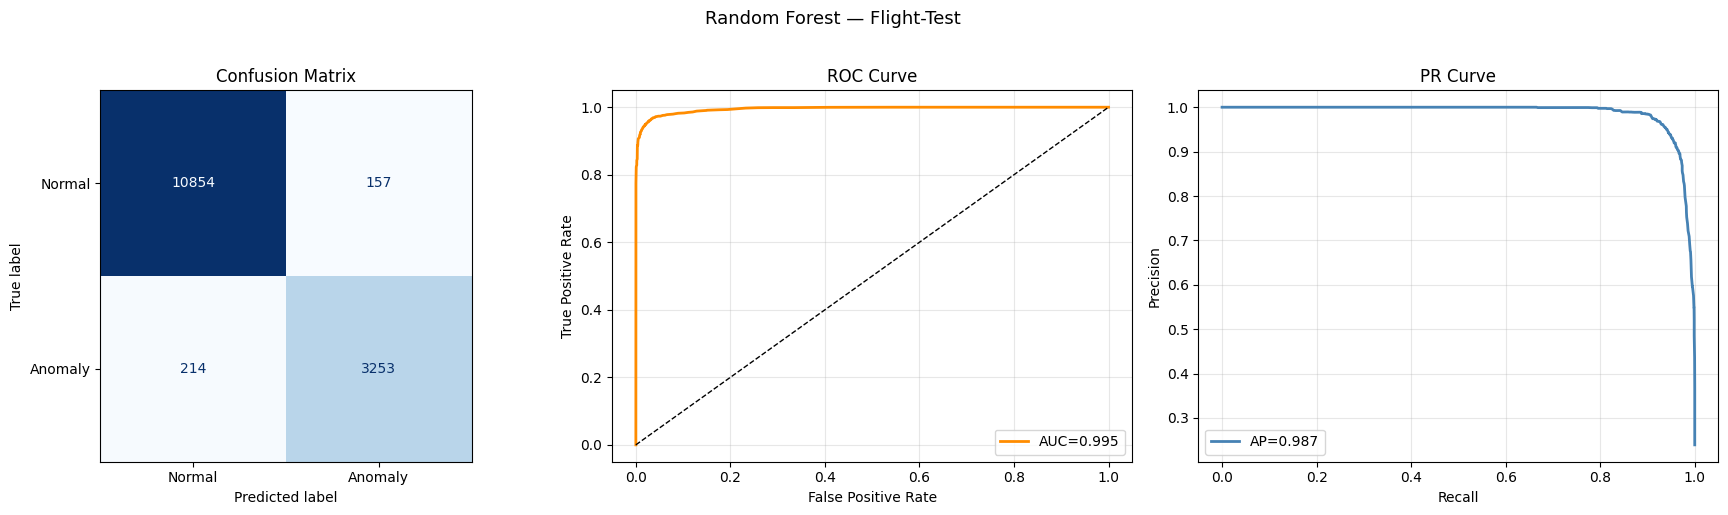


  Random Forest  |  TVAC
  Accuracy  : 0.9981
  Precision : 0.9914
  Recall    : 0.9759
  F1-Score  : 0.9836
  ROC-AUC   : 0.9992
  PR-AUC    : 0.9979

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     11517
     Anomaly       0.99      0.98      0.98       705

    accuracy                           1.00     12222
   macro avg       0.99      0.99      0.99     12222
weighted avg       1.00      1.00      1.00     12222



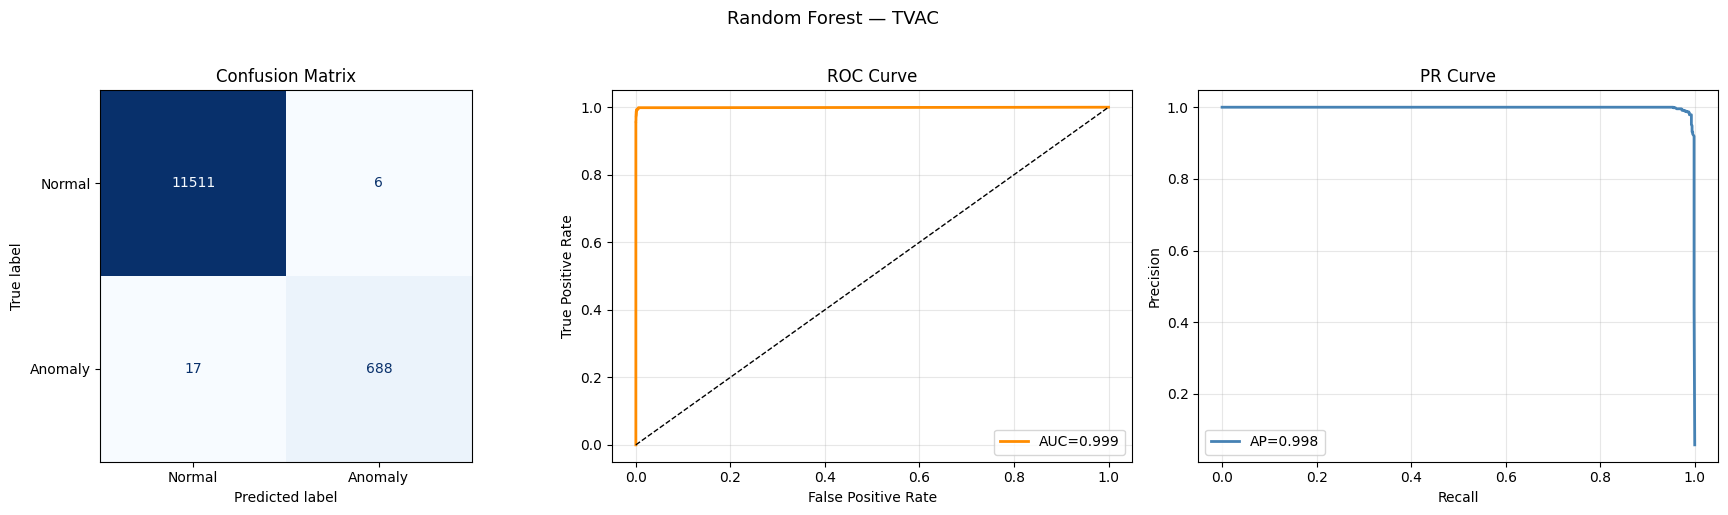

(RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                        random_state=42),
 array([0, 0, 0, ..., 0, 0, 0], shape=(12222,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(12222,)))

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1)
evaluate_model(rf, X_ft, y_ft, "Random Forest", "Flight-Test")
evaluate_model(rf, X_tv, y_tv, "Random Forest", "TVAC")

SVM